In [64]:
#setup
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Telco Churn Analysis") \
    .getOrCreate()


In [41]:
#upload
from google.colab import files
uploaded = files.upload()



Saving Telco-Customer-Churn.csv to Telco-Customer-Churn (1).csv


In [65]:
#READ DATA
df = spark.read.csv(
    "Telco-Customer-Churn.csv",
    header=True,
    inferSchema=True
)

df.show(5)
df.printSchema()


+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [66]:
#Data Cleaning
from pyspark.sql.functions import col, regexp_replace

# Fix TotalCharges
df = df.withColumn("TotalCharges", regexp_replace("TotalCharges", " ", ""))
df = df.withColumn("TotalCharges", col("TotalCharges").cast("double"))

# Drop missing rows
df = df.dropna()

# Drop duplicates
df = df.dropDuplicates()

df.show(5)



+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|1452-KIOVK|  Male|            0|     No|       Yes|    22|         Yes|          Yes|    Fiber optic|            No|         Yes|              No|         No|        Yes|    

In [67]:
#Feature Engineering
from pyspark.sql.functions import when

df = df.withColumn("ChurnLabel", when(col("Churn") == "Yes", 1).otherwise(0))


In [68]:
#Converting Categorical to Numerical
from pyspark.ml.feature import StringIndexer

categorical_cols = [c for c in df.columns if df.schema[c].dataType == "string" and c not in ["customerID"]]

indexers = [StringIndexer(inputCol=c, outputCol=c+"_Idx") for c in categorical_cols]

from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

df.show(5)


+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+----------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|ChurnLabel|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+----------+
|1452-KIOVK|  Male|            0|     No|       Yes|    22|         Yes|          Yes|    Fiber optic|            No|         Yes|            

In [69]:
#Model Churn Prediction (Random Forest)
from pyspark.ml.feature import VectorAssembler

feature_cols = [c+"_Idx" for c in categorical_cols] + ["tenure", "MonthlyCharges", "TotalCharges"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

final_df = assembler.transform(df).select("features", "ChurnLabel")



In [70]:
#Train-test split
train, test = final_df.randomSplit([0.7, 0.3], seed=42)


In [71]:
#Train Model
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="ChurnLabel", featuresCol="features")
model = rf.fit(train)


In [72]:
#Evaluate
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = model.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="ChurnLabel")
auc = evaluator.evaluate(predictions)

print("AUC =", auc)


AUC = 0.7910914369625804


In [89]:
#RDD vs DataFrame vs Spark SQL

#PySpark RDDs
#(The example Gender was chosen because it’s a simple
#categorical column that’s easy to aggregate and compare)

import time

start = time.time()
rdd_result = df.rdd.map(lambda x: (x["gender"], 1)).reduceByKey(lambda a,b: a+b).collect()
rdd_time = time.time() - start

print("RDD Time:", rdd_time)


RDD Time: 1.2989935874938965


In [74]:
#PySpark DataFrame
start = time.time()
df_result = df.groupBy("gender").count().collect()
df_time = time.time() - start

print("DataFrame Time:", df_time)


DataFrame Time: 0.6859471797943115


In [75]:
#Spark SQL
df.createOrReplaceTempView("telco")

start = time.time()
sql_result = spark.sql("SELECT gender, COUNT(*) FROM telco GROUP BY gender").collect()
sql_time = time.time() - start

print("SQL Time:", sql_time)


SQL Time: 0.5302338600158691


In [76]:
#NETWORK CONGESTION ANALYSIS
from pyspark.sql.functions import rand

df2 = df.withColumn("NetworkLoad", (rand() * 100))

df2.groupBy("InternetService").avg("NetworkLoad").show()


+---------------+------------------+
|InternetService|  avg(NetworkLoad)|
+---------------+------------------+
|    Fiber optic|50.269353106869914|
|             No| 50.31564248417224|
|            DSL|49.814297396585836|
+---------------+------------------+



In [77]:
#SERVICE PLAN PROFITABILITY
from pyspark.sql.functions import expr

df2 = df2.withColumn("Cost", expr("MonthlyCharges * 0.6"))
df2 = df2.withColumn("Profit", expr("MonthlyCharges - Cost"))

df2.groupBy("Contract").avg("Profit").show()


+--------------+------------------+
|      Contract|       avg(Profit)|
+--------------+------------------+
|Month-to-month|26.559396129032244|
|      One year|26.031766304347776|
|      Two year| 24.34894955489618|
+--------------+------------------+



In [78]:
#Churn Risk Score Calculation Using PySpark UDF
from pyspark.sql.functions import round, rand, col
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf

# Add simulated complaints column to df2
df2 = df2.withColumn("Complaints", round(rand()*5))

# Define UDF
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def churn_risk_score(monthly_charges, tenure, complaints):
    if monthly_charges is None or tenure is None or complaints is None:
        return 0.0
    return (0.4 * monthly_charges) + (0.3 * (1 / (tenure + 1))) + (0.3 * complaints)

risk_udf = udf(churn_risk_score, DoubleType())

# Add ChurnRiskScore column
df2 = df2.withColumn("ChurnRiskScore", risk_udf("MonthlyCharges", "tenure", "Complaints"))

# Show results
df2.select("customerID", "MonthlyCharges", "tenure", "Complaints", "ChurnRiskScore").show(5)


+----------+--------------+------+----------+------------------+
|customerID|MonthlyCharges|tenure|Complaints|    ChurnRiskScore|
+----------+--------------+------+----------+------------------+
|1452-KIOVK|          89.1|    22|       5.0| 37.15304347826087|
|4482-EWFMI|          69.7|     2|       3.0|28.880000000000003|
|2077-DDHJK|          70.9|    68|       0.0| 28.36434782608696|
|7538-GWHML|         69.65|     2|       4.0|29.160000000000004|
|7997-EASSD|          81.2|    63|       1.0|32.784687500000004|
+----------+--------------+------+----------+------------------+
only showing top 5 rows



In [79]:
#Creating Temporary View in Spark SQL for Hive Database 'telecom
spark.sql("USE telecom")
df2.createOrReplaceTempView("telco_churn")


In [80]:
#Hive Query – Top 10 Customers by Churn Risk Score
spark.sql("""
SELECT customerID, MonthlyCharges, tenure, Complaints, ChurnRiskScore
FROM telco_churn
ORDER BY ChurnRiskScore DESC
LIMIT 10
""").show()


+----------+--------------+------+----------+------------------+
|customerID|MonthlyCharges|tenure|Complaints|    ChurnRiskScore|
+----------+--------------+------+----------+------------------+
|9924-JPRMC|         118.2|    72|       5.0|48.784109589041094|
|5734-EJKXG|         118.6|    61|       4.0| 48.64483870967742|
|5989-AXPUC|         118.6|    68|       4.0| 48.64434782608696|
|6650-BWFRT|        117.15|    72|       5.0|  48.3641095890411|
|0675-NCDYU|         116.4|    72|       5.0|48.064109589041095|
|9739-JLPQJ|         117.5|    72|       3.0| 47.90410958904109|
|3258-ZKPAI|         116.6|    72|       4.0|47.844109589041096|
|7569-NMZYQ|        118.75|    72|       1.0| 47.80410958904109|
|8984-HPEMB|        118.65|    71|       1.0|47.764166666666675|
|2889-FPWRM|         117.8|    72|       2.0|  47.7241095890411|
+----------+--------------+------+----------+------------------+



In [81]:
#HIVE WAREHOUSE (SIMULATION INSIDE SPARK SQL)
spark.sql("CREATE DATABASE IF NOT EXISTS telecom")
spark.sql("USE telecom")

df2.createOrReplaceTempView("telco_churn")


In [82]:
#Hive Query 1 – Top churn risks
spark.sql("""
SELECT customerID, MonthlyCharges, ChurnLabel
FROM telco_churn
WHERE ChurnLabel = 1
ORDER BY MonthlyCharges DESC
LIMIT 10
""").show()


+----------+--------------+----------+
|customerID|MonthlyCharges|ChurnLabel|
+----------+--------------+----------+
|8199-ZLLSA|        118.35|         1|
|2889-FPWRM|         117.8|         1|
|2302-ANTDP|        117.45|         1|
|9053-JZFKV|         116.2|         1|
|1444-VVSGW|        115.65|         1|
|0201-OAMXR|        115.55|         1|
|4361-BKAXE|         114.5|         1|
|1555-DJEQW|         114.2|         1|
|9158-VCTQB|         113.6|         1|
|7279-BUYWN|         113.2|         1|
+----------+--------------+----------+



In [83]:
#Hive Query 2 – Network congestion
spark.sql("""
SELECT InternetService, AVG(NetworkLoad) AS avg_load
FROM telco_churn
GROUP BY InternetService
ORDER BY avg_load DESC
""").show()


+---------------+------------------+
|InternetService|          avg_load|
+---------------+------------------+
|             No| 50.31564248417224|
|    Fiber optic|50.269353106869914|
|            DSL|49.814297396585836|
+---------------+------------------+



In [84]:
#Hive Query 3 – Complaints by Category
from pyspark.sql.functions import round

df3 = df2.withColumn("Complaints", round(rand()*5))
df3.createOrReplaceTempView("telco_churn2")

spark.sql("""
SELECT Contract, SUM(Complaints) AS TotalComplaints
FROM telco_churn2
GROUP BY Contract
""").show()


+--------------+---------------+
|      Contract|TotalComplaints|
+--------------+---------------+
|Month-to-month|         9928.0|
|      One year|         3615.0|
|      Two year|         4165.0|
+--------------+---------------+



In [85]:
#Hive Query 4 – Profitability per service plan
spark.sql("""
SELECT Contract, AVG(Profit) AS AvgProfit
FROM telco_churn
GROUP BY Contract
ORDER BY AvgProfit DESC
""").show()


+--------------+------------------+
|      Contract|         AvgProfit|
+--------------+------------------+
|Month-to-month|26.559396129032244|
|      One year|26.031766304347776|
|      Two year| 24.34894955489618|
+--------------+------------------+



In [86]:
#Converting to pandas
#Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pdf = df2.select("MonthlyCharges", "ChurnLabel").sample(0.05).toPandas()
pdf = df2.select("ChurnRiskScore", "Contract", "InternetService", "ChurnLabel").sample(0.1).toPandas()


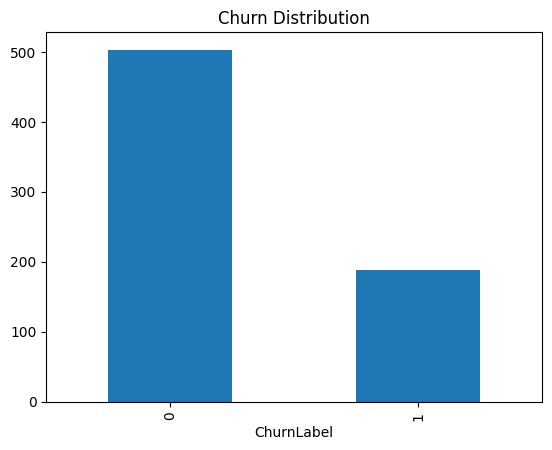

In [87]:
#Churn distribution
pdf["ChurnLabel"].value_counts().plot(kind="bar")
plt.title("Churn Distribution")
plt.show()


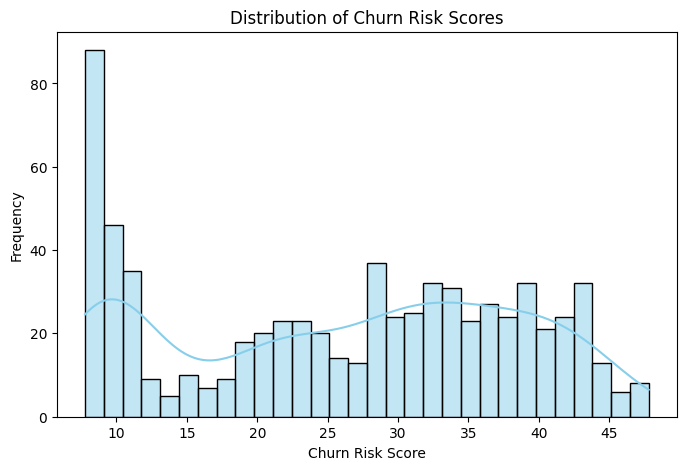

In [59]:
#Histogram – Churn Risk Distribution
plt.figure(figsize=(8,5))
sns.histplot(pdf["ChurnRiskScore"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Churn Risk Scores")
plt.xlabel("Churn Risk Score")
plt.ylabel("Frequency")
plt.show()


/tmp/ipython-input-3254112266.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Contract", y="ChurnRiskScore", data=avg_contract, palette="viridis")


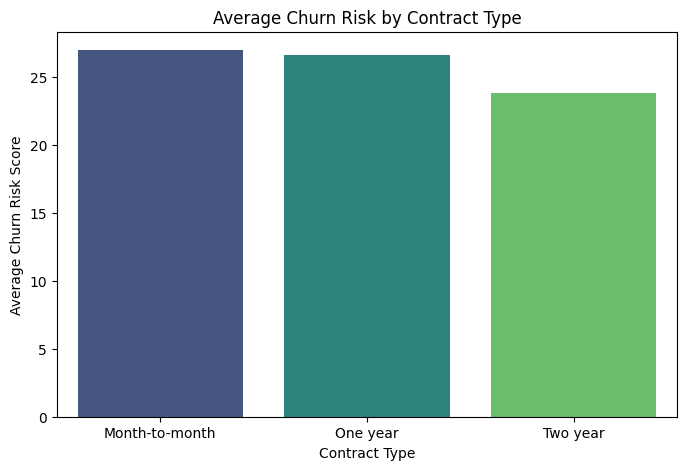

In [62]:
#Bar Chart – Average Churn Risk by Contract Type
avg_contract = pdf.groupby("Contract")["ChurnRiskScore"].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x="Contract", y="ChurnRiskScore", data=avg_contract, palette="viridis")
plt.title("Average Churn Risk by Contract Type")
plt.xlabel("Contract Type")
plt.ylabel("Average Churn Risk Score")
plt.show()


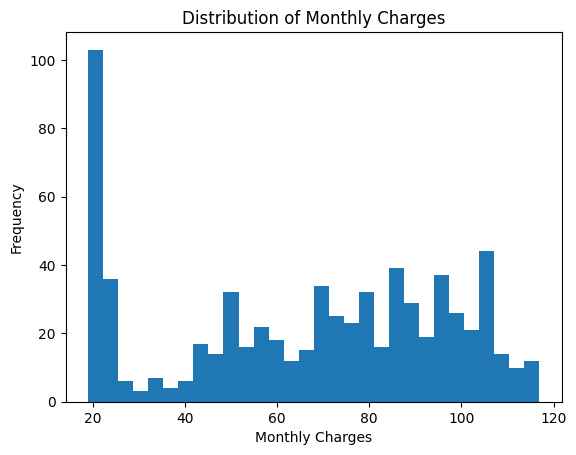

In [29]:
#Histogram – Monthly Charges Distribution
pdf = df2.select("MonthlyCharges").sample(0.10).toPandas()

plt.hist(pdf["MonthlyCharges"], bins=30)
plt.title("Distribution of Monthly Charges")
plt.xlabel("Monthly Charges")
plt.ylabel("Frequency")
plt.show()


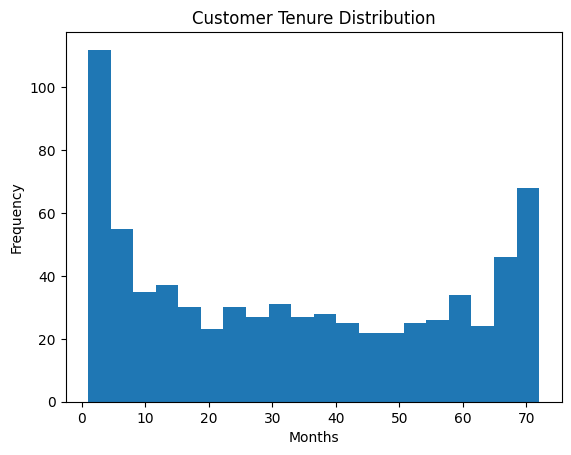

In [30]:
#Histogram – Tenure Distribution
pdf = df2.select("tenure").sample(0.10).toPandas()

plt.hist(pdf["tenure"], bins=20)
plt.title("Customer Tenure Distribution")
plt.xlabel("Months")
plt.ylabel("Frequency")
plt.show()


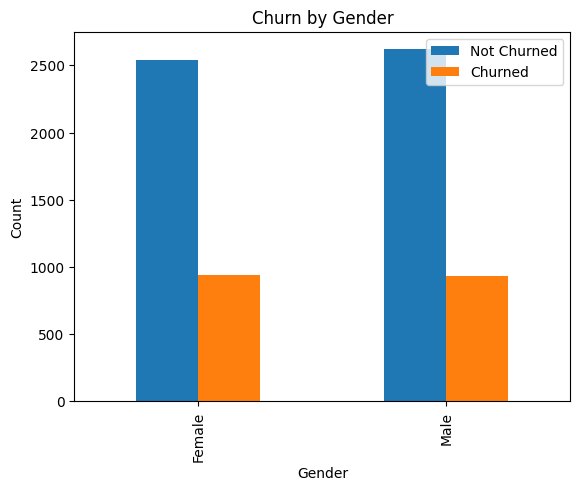

In [31]:
#Bar Chart – Churn Rate by Gender
pdf = df2.groupBy("gender", "ChurnLabel").count().toPandas()

pdf.pivot(index="gender", columns="ChurnLabel", values="count").plot(kind="bar")
plt.title("Churn by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(["Not Churned", "Churned"])
plt.show()


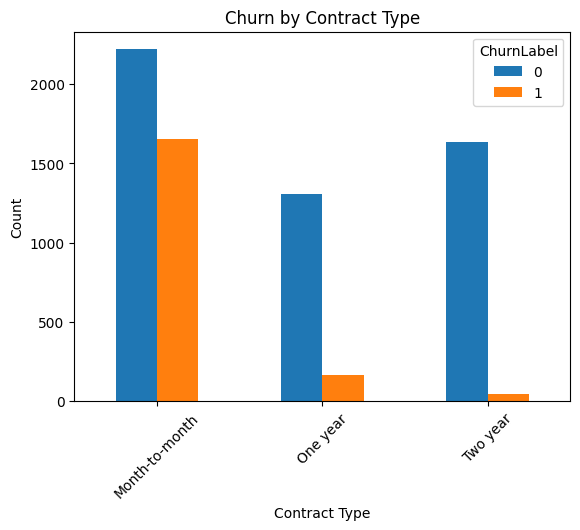

In [32]:
#Bar Chart – Churn Rate by Contract Type
pdf = df2.groupBy("Contract", "ChurnLabel").count().toPandas()

pdf.pivot(index="Contract", columns="ChurnLabel", values="count").plot(kind="bar")
plt.title("Churn by Contract Type")
plt.xlabel("Contract Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


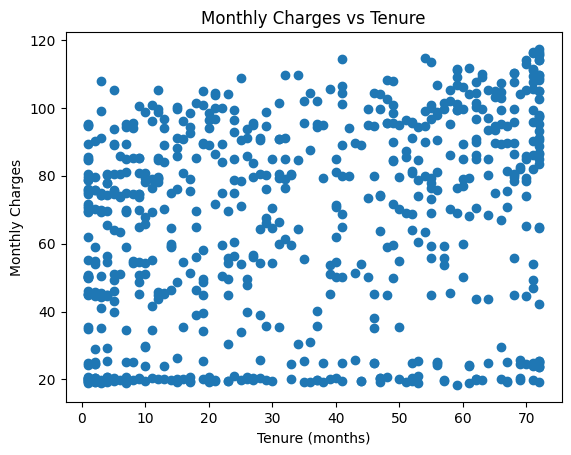

In [33]:
#Scatter Plot – Monthly Charges vs Tenure
pdf = df2.select("MonthlyCharges", "tenure").sample(0.10).toPandas()

plt.scatter(pdf["tenure"], pdf["MonthlyCharges"])
plt.title("Monthly Charges vs Tenure")
plt.xlabel("Tenure (months)")
plt.ylabel("Monthly Charges")
plt.show()


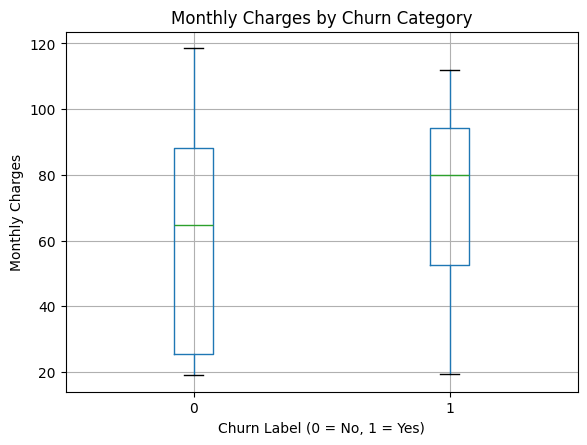

In [34]:
#Boxplot – Monthly Charges for Churn vs Not Churn
pdf = df2.select("MonthlyCharges", "ChurnLabel").sample(0.10).toPandas()

pdf.boxplot(column="MonthlyCharges", by="ChurnLabel")
plt.title("Monthly Charges by Churn Category")
plt.suptitle("")
plt.xlabel("Churn Label (0 = No, 1 = Yes)")
plt.ylabel("Monthly Charges")
plt.show()


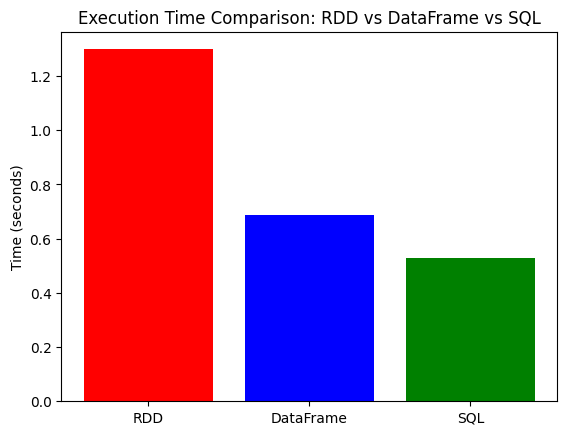

In [91]:
#Execution Time Comparison: RDD vs DataFrame vs SQL
operations = ['RDD', 'DataFrame', 'SQL']
times = [rdd_time, df_time, sql_time]

plt.bar(operations, times, color=['red', 'blue', 'green'])
plt.title('Execution Time Comparison: RDD vs DataFrame vs SQL')
plt.ylabel('Time (seconds)')
plt.show()

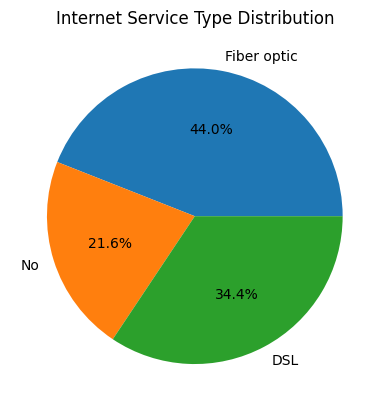

In [35]:
#Pie Chart – Internet Service Type Distribution
pdf = df2.groupBy("InternetService").count().toPandas()

plt.pie(pdf["count"], labels=pdf["InternetService"], autopct='%1.1f%%')
plt.title("Internet Service Type Distribution")
plt.show()


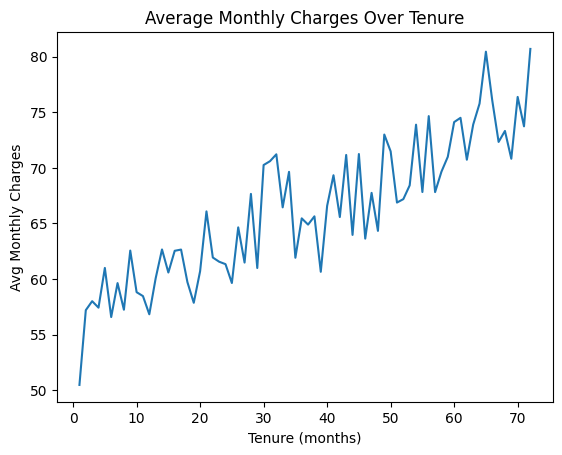

In [37]:
#Line Chart – Average Charges vs Tenure
avg_df = df2.groupBy("tenure").avg("MonthlyCharges").orderBy("tenure").toPandas()

plt.plot(avg_df["tenure"], avg_df["avg(MonthlyCharges)"])
plt.title("Average Monthly Charges Over Tenure")
plt.xlabel("Tenure (months)")
plt.ylabel("Avg Monthly Charges")
plt.show()
